In [1]:
import torch
from torchvision import datasets, transforms

In [2]:
# Define transformations for data augmentation and preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])



In [3]:
pwd

'/user/ssheri'

In [23]:
data = datasets.ImageFolder('/user/ssheri/train_dataset',transform=transform)

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [6]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):

        super(Block, self).__init__()
        # Every Resedual block will have two convolution layers with batch normalization done before applying relu
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.batchnorm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.batchnorm2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample

    def forward(self, x):
        identity = x.clone()

        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.batchnorm2(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x


In [7]:

class ResNet(nn.Module):
  
  def __init__(self, block, layers, image_channels, num_classes):
    super(ResNet, self).__init__()
    self.expansion = 1 # expansion factor is 1 for resnet 18, it is 4 for resnet 50,101 and 152
    self.in_channels = 64
    self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3, bias=False) # Extracts the low level features from input image
    self.bn1 = nn.BatchNorm2d(64)
    self.relu = nn.ReLU()
    self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    # Feature map size of 112 * 112
    self.layer1 = self.make_layer(block, layers[0], out_channels=64, stride=1) # Two convolutions with 64 outputs
    self.layer2 = self.make_layer(block, layers[1], out_channels=128, stride=2) # Two convolution with 128 outputs
    self.layer3 = self.make_layer(block, layers[2], out_channels=256, stride=2) # Two convolutions with 256 outputs
    self.layer4 = self.make_layer(block, layers[3], out_channels=512, stride=2) # Two convolution with 512 outputs
    # Feature map size of 7 * 7
    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    self.fc = nn.Linear(512 * self.expansion, num_classes)
# Increasing the filter size will help us to create more deep model and capture complex models
  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)

    x = self.avgpool(x)
    x = torch.flatten(x,1)
    x = self.fc(x)

    return x

  def make_layer(self, block, num_residual_blocks, out_channels, stride):
    identity_downsample = None # initially identity_downsample is none
    layers = []

    if stride != 1 or self.in_channels != self.expansion * out_channels:
        identity_downsample = nn.Sequential(
            nn.Conv2d(self.in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(self.expansion * out_channels)
        )
        # when above case occurs we create a identity_downsample with 1*1 conv layer to match number of channels

    layers.append(block(self.in_channels, out_channels, identity_downsample, stride)) # append the first residual block with matched dimensions to layers
    self.in_channels = out_channels * self.expansion # update input channels

    for i in range(num_residual_blocks - 1): # append remaining residual blocks
        layers.append(block(self.in_channels, out_channels))

    return nn.Sequential(*layers)

In [8]:
def ResNet18(img_channel=3, num_classes=len(data.classes)):
    return ResNet(Block, [2, 2, 2, 2], img_channel, num_classes)


In [9]:
from torch.utils.data import random_split, DataLoader

In [10]:
train_size = int(0.7 * len(data))
rem = len(data) - train_size
test=int(rem/2)

train_data, test_data,val_data = random_split(data, [train_size,test,test])

In [11]:
len(train_data)

50446

In [12]:
train_loader = DataLoader(train_data, batch_size=35, shuffle=True)
test_loader = DataLoader(test_data, batch_size=35, shuffle=False)
val_loader = DataLoader(val_data,batch_size = 35, shuffle = False)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [24]:
len(data.classes)

15

In [15]:
model = ResNet18(num_classes=len(data.classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)

In [16]:


# 5. Train the model
num_epochs = 20
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss = 0.0
    train_correct = 0
    val_loss = 0.0
    val_correct = 0

    # Training loop
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += torch.sum(preds == labels.data)

    # Validation loop
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += torch.sum(preds == labels.data)

    train_loss /= len(train_data)
    train_accuracy = 100.0 * train_correct / len(train_data)
    val_loss /= len(val_data)
    val_accuracy = 100.0 * val_correct / len(val_data)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')




Epoch [1/20], Train Loss: 2.1320, Train Acc: 31.75%, Val Loss: 1.9725, Val Acc: 36.27%
Epoch [2/20], Train Loss: 1.6519, Train Acc: 46.84%, Val Loss: 1.6091, Val Acc: 49.03%
Epoch [3/20], Train Loss: 1.3701, Train Acc: 56.00%, Val Loss: 1.4189, Val Acc: 55.87%
Epoch [4/20], Train Loss: 1.1822, Train Acc: 62.09%, Val Loss: 1.1719, Val Acc: 61.62%
Epoch [5/20], Train Loss: 1.0643, Train Acc: 65.79%, Val Loss: 1.0953, Val Acc: 65.05%
Epoch [6/20], Train Loss: 0.9563, Train Acc: 69.03%, Val Loss: 1.2631, Val Acc: 61.28%
Epoch [7/20], Train Loss: 0.8865, Train Acc: 71.41%, Val Loss: 1.1191, Val Acc: 64.69%
Epoch [8/20], Train Loss: 0.8123, Train Acc: 73.74%, Val Loss: 1.0815, Val Acc: 66.17%
Epoch [9/20], Train Loss: 0.7505, Train Acc: 75.73%, Val Loss: 1.0071, Val Acc: 68.15%
Epoch [10/20], Train Loss: 0.6856, Train Acc: 77.52%, Val Loss: 1.2341, Val Acc: 64.84%
Epoch [11/20], Train Loss: 0.6338, Train Acc: 79.12%, Val Loss: 1.4855, Val Acc: 58.43%
Epoch [12/20], Train Loss: 0.5789, Train 

In [17]:
correct = 0
total = 0
y_true = []
y_pred = []
test_losses = []
test_accuracies = []
test_loss = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs= inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
test_loss /= len(val_loader)
test_accuracy = 100 * correct / total
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

print('Accuracy of the network on the test images: %d %%' % (test_accuracy))
print('Test loss is ',(test_loss))

Accuracy of the network on the test images: 65 %
Test loss is  1.4094692690472772


### We will apply drop outs and early stopping in order to avoid over fitting

In [18]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):

        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.batchnorm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.batchnorm2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        identity = x.clone()

        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.conv2(x)
        x = self.batchnorm2(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        x = self.dropout(x)
        return x


In [19]:

class ResNet(nn.Module):
  
  def __init__(self, block, layers, image_channels, num_classes):
    super(ResNet, self).__init__()
    self.expansion = 1 # expansion factor is 1 for resnet 18, it is 4 for resnet 50,101 and 152
    self.in_channels = 64
    self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3, bias=False) # Extracts the low level features from input image
    self.bn1 = nn.BatchNorm2d(64)
    self.relu = nn.ReLU()
    self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    # Feature map size of 112 * 112
    self.layer1 = self.make_layer(block, layers[0], out_channels=64, stride=1) # Two convolutions with 64 outputs
    self.layer2 = self.make_layer(block, layers[1], out_channels=128, stride=2) # Two convolution with 128 outputs
    self.layer3 = self.make_layer(block, layers[2], out_channels=256, stride=2) # Two convolutions with 256 outputs
    self.layer4 = self.make_layer(block, layers[3], out_channels=512, stride=2) # Two convolution with 512 outputs
    # Feature map size of 7 * 7
    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    self.fc = nn.Linear(512 * self.expansion, num_classes)
# Increasing the filter size will help us to create more deep model and capture complex models
  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)

    x = self.avgpool(x)
    x = torch.flatten(x,1)
    x = self.fc(x)

    return x

  def make_layer(self, block, num_residual_blocks, out_channels, stride):
    identity_downsample = None # initially identity_downsample is none
    layers = []

    if stride != 1 or self.in_channels != self.expansion * out_channels:
        identity_downsample = nn.Sequential(
            nn.Conv2d(self.in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(self.expansion * out_channels)
        )
        # when above case occurs we create a identity_downsample with 1*1 conv layer to match number of channels

    layers.append(block(self.in_channels, out_channels, identity_downsample, stride)) # append the first residual block with matched dimensions to layers
    self.in_channels = out_channels * self.expansion # update input channels

    for i in range(num_residual_blocks - 1): # append remaining residual blocks
        layers.append(block(self.in_channels, out_channels))

    return nn.Sequential(*layers)

In [25]:
def ResNet18(img_channel=3, num_classes=len(data.classes)):
    return ResNet(Block, [2, 2, 2, 2], img_channel, num_classes)


In [26]:
model = ResNet18(num_classes=len(data.classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)

In [27]:

num_epochs = 20
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
patience = 4
best_loss = float('inf')

# Training loop
for epoch in range(num_epochs):
    model.train()
    training_loss = 0.0
    total = 0
    correct = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        training_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    training_loss /= len(train_loader)
    train_losses.append(training_loss)
    train_accuracy = 100 * correct / total
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    val_loss /= len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    
    if val_loss<best_loss:
        best_loss = val_loss
        counter = 0
    else:
        counter = 1
    if counter == patience:
        print('early stopping occured')
        torch.save(model.state_dict(), 'resetearly.pth')
        break
    
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {training_loss:.4f},Train_accuracy : {train_accuracy:.4f}%, Val Loss: {val_loss:.4f}, Val_accuracy: {val_accuracy:.4f}%")

print('Finished Training')

Epoch [1/20] Train Loss: 2.2160,Train_accuracy : 28.4958%, Val Loss: 1.8208, Val_accuracy: 41.7576%
Epoch [2/20] Train Loss: 1.7262,Train_accuracy : 43.9777%, Val Loss: 1.5818, Val_accuracy: 48.6494%
Epoch [3/20] Train Loss: 1.4811,Train_accuracy : 52.2142%, Val Loss: 1.5511, Val_accuracy: 50.6846%
Epoch [4/20] Train Loss: 1.3182,Train_accuracy : 57.5725%, Val Loss: 1.3890, Val_accuracy: 55.3377%
Epoch [5/20] Train Loss: 1.2223,Train_accuracy : 60.5776%, Val Loss: 1.2716, Val_accuracy: 59.2969%
Epoch [6/20] Train Loss: 1.1434,Train_accuracy : 63.2934%, Val Loss: 1.4426, Val_accuracy: 53.9593%
Epoch [7/20] Train Loss: 1.0849,Train_accuracy : 65.0914%, Val Loss: 1.1683, Val_accuracy: 63.2655%
Epoch [8/20] Train Loss: 1.0411,Train_accuracy : 66.6475%, Val Loss: 1.2491, Val_accuracy: 61.1471%
Epoch [9/20] Train Loss: 1.0019,Train_accuracy : 67.6050%, Val Loss: 1.0792, Val_accuracy: 66.0222%
Epoch [10/20] Train Loss: 0.9679,Train_accuracy : 68.9609%, Val Loss: 1.2228, Val_accuracy: 62.3497%

In [28]:
correct = 0
total = 0
y_true = []
y_pred = []
test_losses = []
test_accuracies = []
test_loss = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs= inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
test_loss /= len(val_loader)
test_accuracy = 100 * correct / total
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

print('Accuracy of the network on the test images: %d %%' % (test_accuracy))
print('Test loss is ',(test_loss))

Accuracy of the network on the test images: 71 %
Test loss is  0.8887225414556978


In [29]:
import matplotlib.pyplot as plt

In [30]:
train_accuracies

[28.495817309598383,
 43.97771874876105,
 52.21424889981366,
 57.5724537128811,
 60.57764738532292,
 63.293422669785514,
 65.0913848471633,
 66.64750426198312,
 67.60496372358561,
 68.96086904809103,
 69.64080402806962,
 70.23748166356104,
 71.30396860008722,
 71.93038100146691,
 72.18015303492844,
 73.1832058042263,
 73.25258692463228,
 73.82151211196131,
 74.23779883439718,
 74.44594219561512]

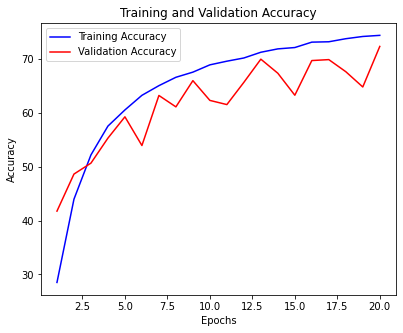

In [31]:

epochs = range(1, num_epochs + 1)
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracies, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


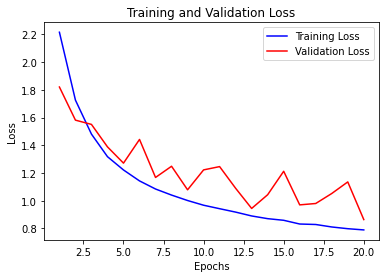

In [32]:
plt.plot(epochs, train_losses, 'b', label='Training Loss')
plt.plot(epochs, val_losses, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [33]:
torch.save(model.state_dict(), 'resnet_332.pth')

In [34]:
from sklearn.metrics import confusion_matrix

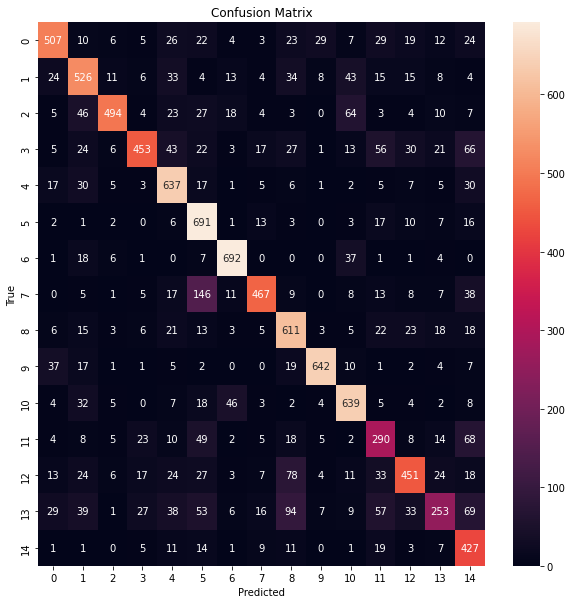

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Reference:
https://www.run.ai/guides/deep-learning-for-computer-vision/pytorch-resnet

https://www.youtube.com/watch?v=DkNIBBBvcPs&t=1393s

https://www.youtube.com/watch?v=GWt6Fu05voI&t=786s
